In [1]:
import pandas as pd
import numpy as np
import datetime as datetime
import math
from geopy import distance
from geopy.distance import geodesic
import matplotlib.pyplot as plt
import seaborn as sns

In [80]:
data_folder = './data/'

# Method returning the dataframe obtained from the csv file named "name".
def get_dataframe(name):
    return pd.read_csv(data_folder + name, compression='gzip', sep='\t',header = None)

b_edges = get_dataframe('loc-brightkite_edges.txt.gz')
brightkite_checkins = get_dataframe('loc-brightkite_totalCheckins.txt.gz')
g_edges = get_dataframe('loc-gowalla_edges.txt.gz')
gowalla_checkins = get_dataframe('loc-gowalla_totalCheckins.txt.gz')


In [81]:
#Renaming the columns in the given dataframes with the names given.
b_checkins = brightkite_checkins.rename(columns= {0: 'user', 1: 'checkin_time', 2: 'latitude', 
                                                       3: 'longitude', 4: 'location_id'})
g_checkins = gowalla_checkins.rename(columns= {0: 'user', 1: 'checkin_time', 2: 'latitude', 
                                                       3: 'longitude', 4: 'location_id'})

#Checking the number of checkins we have in each dataframe.
print("Number of checkins in Brightkite: " + str(len(b_checkins)))
print("Number of checkins in Gowalla: " + str(len(g_checkins)))
b_checkins.head()

Number of checkins in Brightkite: 4747287
Number of checkins in Gowalla: 6442892


,user,checkin_time,latitude,longitude,location_id
0,0,2010-10-17T01:48:53Z,39.747652,-104.992510,88c46bf20db295831bd2d1718ad7e6f5
1,0,2010-10-16T06:02:04Z,39.891383,-105.070814,7a0f88982aa015062b95e3b4843f9ca2
2,0,2010-10-16T03:48:54Z,39.891077,-105.068532,dd7cd3d264c2d063832db506fba8bf79
3,0,2010-10-14T18:25:51Z,39.750469,-104.999073,9848afcc62e500a01cf6fbf24b797732f8963683
4,0,2010-10-14T00:21:47Z,39.752713,-104.996337,2ef143e12038c870038df53e0478cefc


In [82]:
# Checking for rows with impossible longitudes/latitudes and removing them if needed.

max_abs_latitude = 90
max_abs_longitude = 180

# Method verifying that the longitude and latitude values of row are valid.
def check_lat_long(row):
    return ((abs(row['latitude']) <= max_abs_latitude) & (abs(row['longitude']) <= max_abs_longitude))

# Any row with a "False" value for check_lat_long will be dropped from the dataframe.
b_checkins = b_checkins[b_checkins.apply(lambda row: check_lat_long(row), axis=1)]
g_checkins = g_checkins[g_checkins.apply(lambda row: check_lat_long(row), axis=1)]

print("Number of checkins in Brightkite: " + str(len(b_checkins)))
print("Number of checkins in Gowalla: " + str(len(g_checkins)))

Number of checkins in Brightkite: 4747172
Number of checkins in Gowalla: 6442863


In [139]:
# Creating a mask for all checkin locations that are not (0,0).
b_non_zero_mask = b_checkins.apply(lambda x : (x['latitude']!=0)&(x['longitude']!=0),axis = 1)
g_non_zero_mask = g_checkins.apply(lambda x : (x['latitude']!=0)&(x['longitude']!=0),axis = 1)

print("There are " + str((b_non_zero_mask == False).sum()) + " checkins with (0,0) as coordinates pair.")

There are 0 checkins with (0,0) as coordinates pair.


In [140]:
# Filtering out all the checkins made at location (lat,long) = (0,0).
b_checkins = b_checkins[b_non_zero_mask]
g_checkins = g_checkins[g_non_zero_mask]
#b_checkins.head()

In [85]:
n_america_top_right = (73.860249, -56.419743)
n_america_bottom_left = (9.665856, -169.442213)
s_america_top_right = (9.665856, -33.387459)
s_america_bottom_left = (-57.611456, -89.076457)
europe_top_right = (71.997783, 51.799653)
europe_bottom_left = (36.813173, -26.510956)
asia_top_right = (75.061389, 180)
asia_bottom_left = (-8.890023, 57.803896)
africa_bottom_left = (-37.719449, -26.510956)
africa_top_right = (36.813173, 57.803896)
oceania_bottomn_left = (-49.690863, 103.607883)
oceania_top_right = (-8.081996, 180)

n_america = [n_america_bottom_left, n_america_top_right]
s_america = [s_america_bottom_left, s_america_top_right]
europe = [europe_bottom_left, europe_top_right]
asia = [asia_bottom_left, asia_top_right]
africa = [africa_bottom_left, africa_top_right]
oceania = [oceania_bottomn_left, oceania_top_right]

In [86]:
def is_in_continent(row, continent):
    continent_lat_range = range(int(continent[0][0]), int(continent[1][0])+1)
    continent_long_range = range(int(continent[0][1]), int(continent[1][1])+1)
    return (int(row['latitude']) in continent_lat_range) & (int(row['longitude']) in continent_long_range)

In [141]:
b_checkins['is_in_n_america'] = b_checkins.apply(lambda row: is_in_continent(row, n_america), axis=1)
g_checkins['is_in_n_america'] = g_checkins.apply(lambda row: is_in_continent(row, n_america), axis=1)

#b_checkins.head()

0
1000
2000
3000
4000
5000
7000
8000
9000
11000
12000
14000
15000
16000
17000
19000
22000
23000
24000
25000
26000
28000
31000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
44000
46000
47000
48000
50000
51000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
65000
66000
67000
70000
71000
72000
73000
76000
79000
83000
84000
86000
87000
88000
89000
90000
93000
94000
95000
98000
99000
100000
101000
102000
104000
105000
106000
107000
108000
109000
110000
111000
112000
113000
114000
115000
117000
118000
119000
120000
122000
124000
126000
127000
128000
129000
133000
135000
136000
138000
139000
140000
143000
144000
145000
147000
148000
150000
151000
152000
155000
156000
157000
159000
162000
163000
164000
166000
167000
170000
172000
173000
174000
176000
178000
180000
181000
182000
186000
187000
189000
191000
194000
201000
202000
204000
206000
208000
209000
210000
211000
212000
213000
215000
216000
219000
222000
223000
224000
226000
228000
230000
231000
233000
23500

1897000
1901000
1904000
1907000
1909000
1911000
1914000
1920000
1924000
1925000
1926000
1928000
1929000
1930000
1932000
1933000
1934000
1935000
1936000
1937000
1938000
1940000
1943000
1946000
1948000
1949000
1950000
1952000
1953000
1955000
1956000
1957000
1958000
1961000
1963000
1968000
1970000
1972000
1976000
1979000
1982000
1983000
1984000
1992000
1995000
1996000
1997000
1998000
1999000
2000000
2001000
2003000
2004000
2005000
2018000
2019000
2020000
2021000
2023000
2024000
2025000
2026000
2036000
2038000
2041000
2045000
2048000
2050000
2052000
2053000
2056000
2058000
2061000
2062000
2065000
2070000
2074000
2078000
2081000
2082000
2083000
2084000
2090000
2091000
2093000
2094000
2095000
2098000
2099000
2101000
2103000
2104000
2109000
2110000
2111000
2113000
2114000
2116000
2120000
2122000
2124000
2125000
2127000
2133000
2134000
2135000
2137000
2138000
2139000
2140000
2141000
2143000
2144000
2145000
2148000
2149000
2152000
2153000
2155000
2156000
2157000
2159000
2161000
2164000
2165000


3974000
3977000
3981000
3982000
3984000
3985000
3988000
3989000
3992000
3994000
3995000
3996000
4001000
4002000
4003000
4005000
4006000
4008000
4009000
4010000
4019000
4020000
4021000
4022000
4023000
4025000
4028000
4029000
4031000
4033000
4035000
4036000
4038000
4039000
4046000
4053000
4054000
4057000
4058000
4059000
4071000
4073000
4078000
4085000
4086000
4090000
4091000
4092000
4097000
4100000
4101000
4103000
4104000
4107000
4109000
4111000
4114000
4118000
4119000
4120000
4124000
4127000
4129000
4130000
4131000
4132000
4133000
4135000
4136000
4138000
4139000
4142000
4144000
4147000
4148000
4149000
4150000
4151000
4152000
4154000
4155000
4156000
4157000
4160000
4163000
4166000
4171000
4173000
4178000
4183000
4184000
4185000
4187000
4188000
4189000
4190000
4191000
4192000
4195000
4199000
4204000
4205000
4208000
4211000
4212000
4214000
4216000
4218000
4220000
4221000
4222000
4225000
4228000
4229000
4230000
4232000
4233000
4234000
4239000
4248000
4249000
4251000
4252000
4253000
4254000


922000
923000
924000
925000
926000
927000
928000
929000
930000
931000
932000
933000
934000
935000
936000
937000
938000
939000
940000
941000
942000
943000
944000
945000
946000
947000
948000
949000
950000
951000
952000
953000
954000
955000
956000
957000
958000
959000
960000
961000
962000
963000
964000
965000
966000
967000
968000
969000
970000
971000
972000
973000
974000
975000
976000
977000
978000
979000
980000
981000
982000
983000
984000
985000
986000
987000
988000
989000
990000
991000
992000
993000
994000
995000
996000
997000
998000
999000
1000000
1001000
1002000
1003000
1004000
1005000
1006000
1007000
1008000
1009000
1010000
1011000
1012000
1013000
1014000
1015000
1016000
1017000
1018000
1019000
1020000
1021000
1022000
1023000
1024000
1025000
1026000
1027000
1028000
1029000
1030000
1031000
1032000
1033000
1034000
1035000
1036000
1037000
1038000
1039000
1040000
1041000
1042000
1043000
1044000
1045000
1046000
1047000
1048000
1049000
1050000
1051000
1052000
1053000
1054000
1055000
105600

1957000
1958000
1959000
1960000
1961000
1962000
1963000
1964000
1965000
1966000
1967000
1968000
1969000
1970000
1971000
1972000
1973000
1974000
1975000
1976000
1977000
1978000
1979000
1980000
1981000
1982000
1983000
1984000
1985000
1986000
1987000
1988000
1989000
1990000
1991000
1992000
1993000
1994000
1995000
1996000
1997000
1998000
1999000
2000000
2001000
2002000
2003000
2004000
2005000
2006000
2007000
2008000
2009000
2010000
2011000
2012000
2013000
2014000
2015000
2016000
2017000
2018000
2019000
2020000
2021000
2022000
2023000
2024000
2025000
2026000
2027000
2028000
2029000
2030000
2031000
2032000
2033000
2034000
2035000
2036000
2037000
2038000
2039000
2040000
2041000
2042000
2043000
2044000
2045000
2046000
2047000
2048000
2049000
2050000
2051000
2052000
2053000
2054000
2055000
2056000
2057000
2058000
2059000
2060000
2061000
2062000
2063000
2064000
2065000
2066000
2067000
2068000
2069000
2070000
2071000
2072000
2073000
2074000
2075000
2076000
2077000
2078000
2079000
2080000
2081000


2985000
2986000
2987000
2988000
2989000
2990000
2991000
2992000
2993000
2994000
2995000
2996000
2997000
2998000
2999000
3000000
3001000
3002000
3003000
3004000
3005000
3006000
3007000
3008000
3009000
3010000
3011000
3012000
3013000
3014000
3015000
3016000
3017000
3018000
3019000
3020000
3021000
3022000
3023000
3024000
3025000
3026000
3027000
3028000
3029000
3030000
3031000
3032000
3033000
3034000
3035000
3036000
3037000
3038000
3039000
3040000
3041000
3042000
3043000
3044000
3045000
3046000
3047000
3048000
3049000
3050000
3051000
3052000
3053000
3054000
3055000
3056000
3057000
3058000
3059000
3060000
3061000
3062000
3063000
3064000
3065000
3066000
3067000
3068000
3069000
3070000
3071000
3072000
3073000
3074000
3075000
3076000
3077000
3078000
3079000
3080000
3081000
3082000
3083000
3084000
3085000
3086000
3087000
3088000
3089000
3090000
3091000
3092000
3093000
3094000
3095000
3096000
3097000
3098000
3099000
3100000
3101000
3102000
3103000
3104000
3105000
3106000
3107000
3108000
3109000


4017000
4018000
4019000
4020000
4021000
4022000
4023000
4024000
4025000
4026000
4027000
4028000
4029000
4030000
4031000
4032000
4033000
4034000
4035000
4036000
4037000
4038000
4039000
4040000
4041000
4042000
4043000
4044000
4045000
4046000
4047000
4048000
4049000
4050000
4051000
4052000
4053000
4054000
4055000
4056000
4057000
4058000
4059000
4060000
4061000
4062000
4063000
4064000
4065000
4066000
4067000
4068000
4069000
4070000
4071000
4072000
4073000
4074000
4075000
4076000
4077000
4078000
4079000
4080000
4081000
4082000
4083000
4084000
4085000
4086000
4087000
4088000
4089000
4090000
4091000
4092000
4093000
4094000
4095000
4096000
4097000
4098000
4099000
4100000
4101000
4102000
4103000
4104000
4105000
4106000
4107000
4108000
4109000
4110000
4111000
4112000
4113000
4114000
4115000
4116000
4117000
4118000
4119000
4120000
4121000
4122000
4123000
4124000
4125000
4126000
4127000
4128000
4129000
4130000
4131000
4132000
4133000
4134000
4135000
4136000
4137000
4138000
4139000
4140000
4141000


5043000
5044000
5045000
5046000
5047000
5048000
5049000
5050000
5051000
5052000
5053000
5054000
5055000
5056000
5057000
5058000
5059000
5060000
5061000
5062000
5063000
5064000
5065000
5066000
5067000
5068000
5069000
5070000
5071000
5072000
5073000
5074000
5075000
5076000
5077000
5078000
5079000
5080000
5081000
5082000
5083000
5084000
5085000
5086000
5087000
5088000
5089000
5090000
5091000
5092000
5093000
5094000
5095000
5096000
5097000
5098000
5099000
5100000
5101000
5102000
5103000
5104000
5105000
5106000
5107000
5108000
5109000
5110000
5111000
5112000
5113000
5114000
5115000
5116000
5117000
5118000
5119000
5120000
5121000
5122000
5123000
5124000
5125000
5126000
5127000
5128000
5129000
5130000
5131000
5132000
5133000
5134000
5135000
5136000
5137000
5138000
5139000
5140000
5141000
5142000
5143000
5144000
5145000
5146000
5147000
5148000
5149000
5150000
5151000
5152000
5153000
5154000
5155000
5156000
5157000
5158000
5159000
5160000
5161000
5162000
5163000
5164000
5165000
5166000
5167000


6074000
6075000
6076000
6077000
6078000
6079000
6080000
6081000
6082000
6083000
6084000
6085000
6086000
6087000
6088000
6089000
6090000
6091000
6092000
6093000
6094000
6095000
6096000
6097000
6098000
6099000
6100000
6101000
6102000
6103000
6104000
6105000
6106000
6107000
6108000
6109000
6110000
6111000
6112000
6113000
6114000
6115000
6116000
6117000
6118000
6119000
6120000
6121000
6122000
6123000
6124000
6125000
6126000
6127000
6128000
6129000
6130000
6131000
6132000
6133000
6134000
6135000
6136000
6137000
6138000
6139000
6140000
6141000
6142000
6143000
6144000
6145000
6146000
6147000
6148000
6149000
6150000
6151000
6152000
6153000
6154000
6155000
6156000
6157000
6158000
6159000
6160000
6161000
6162000
6163000
6164000
6165000
6166000
6167000
6168000
6169000
6170000
6171000
6172000
6173000
6174000
6175000
6176000
6177000
6178000
6179000
6180000
6181000
6182000
6183000
6184000
6185000
6186000
6187000
6188000
6189000
6190000
6191000
6192000
6193000
6194000
6195000
6196000
6197000
6198000


In [142]:
b_checkins['is_in_s_america'] = b_checkins.apply(lambda row: is_in_continent(row, s_america), axis=1)
g_checkins['is_in_s_america'] = g_checkins.apply(lambda row: is_in_continent(row, s_america), axis=1)

#b_checkins.head()

0
1000
2000
3000
4000
5000
7000
8000
9000
11000
12000
14000
15000
16000
17000
19000
22000
23000
24000
25000
26000
28000
31000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
44000
46000
47000
48000
50000
51000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
65000
66000
67000
70000
71000
72000
73000
76000
79000
83000
84000
86000
87000
88000
89000
90000
93000
94000
95000
98000
99000
100000
101000
102000
104000
105000
106000
107000
108000
109000
110000
111000
112000
113000
114000
115000
117000
118000
119000
120000
122000
124000
126000
127000
128000
129000
133000
135000
136000
138000
139000
140000
143000
144000
145000
147000
148000
150000
151000
152000
155000
156000
157000
159000
162000
163000
164000
166000
167000
170000
172000
173000
174000
176000
178000
180000
181000
182000
186000
187000
189000
191000
194000
201000
202000
204000
206000
208000
209000
210000
211000
212000
213000
215000
216000
219000
222000
223000
224000
226000
228000
230000
231000
233000
23500

1893000
1894000
1897000
1901000
1904000
1907000
1909000
1911000
1914000
1920000
1924000
1925000
1926000
1928000
1929000
1930000
1932000
1933000
1934000
1935000
1936000
1937000
1938000
1940000
1943000
1946000
1948000
1949000
1950000
1952000
1953000
1955000
1956000
1957000
1958000
1961000
1963000
1968000
1970000
1972000
1976000
1979000
1982000
1983000
1984000
1992000
1995000
1996000
1997000
1998000
1999000
2000000
2001000
2003000
2004000
2005000
2018000
2019000
2020000
2021000
2023000
2024000
2025000
2026000
2036000
2038000
2041000
2045000
2048000
2050000
2052000
2053000
2056000
2058000
2061000
2062000
2065000
2070000
2074000
2078000
2081000
2082000
2083000
2084000
2090000
2091000
2093000
2094000
2095000
2098000
2099000
2101000
2103000
2104000
2109000
2110000
2111000
2113000
2114000
2116000
2120000
2122000
2124000
2125000
2127000
2133000
2134000
2135000
2137000
2138000
2139000
2140000
2141000
2143000
2144000
2145000
2148000
2149000
2152000
2153000
2155000
2156000
2157000
2159000
2161000


3972000
3973000
3974000
3977000
3981000
3982000
3984000
3985000
3988000
3989000
3992000
3994000
3995000
3996000
4001000
4002000
4003000
4005000
4006000
4008000
4009000
4010000
4019000
4020000
4021000
4022000
4023000
4025000
4028000
4029000
4031000
4033000
4035000
4036000
4038000
4039000
4046000
4053000
4054000
4057000
4058000
4059000
4071000
4073000
4078000
4085000
4086000
4090000
4091000
4092000
4097000
4100000
4101000
4103000
4104000
4107000
4109000
4111000
4114000
4118000
4119000
4120000
4124000
4127000
4129000
4130000
4131000
4132000
4133000
4135000
4136000
4138000
4139000
4142000
4144000
4147000
4148000
4149000
4150000
4151000
4152000
4154000
4155000
4156000
4157000
4160000
4163000
4166000
4171000
4173000
4178000
4183000
4184000
4185000
4187000
4188000
4189000
4190000
4191000
4192000
4195000
4199000
4204000
4205000
4208000
4211000
4212000
4214000
4216000
4218000
4220000
4221000
4222000
4225000
4228000
4229000
4230000
4232000
4233000
4234000
4239000
4248000
4249000
4251000
4252000


923000
924000
925000
926000
927000
928000
929000
930000
931000
932000
933000
934000
935000
936000
937000
938000
939000
940000
941000
942000
943000
944000
945000
946000
947000
948000
949000
950000
951000
952000
953000
954000
955000
956000
957000
958000
959000
960000
961000
962000
963000
964000
965000
966000
967000
968000
969000
970000
971000
972000
973000
974000
975000
976000
977000
978000
979000
980000
981000
982000
983000
984000
985000
986000
987000
988000
989000
990000
991000
992000
993000
994000
995000
996000
997000
998000
999000
1000000
1001000
1002000
1003000
1004000
1005000
1006000
1007000
1008000
1009000
1010000
1011000
1012000
1013000
1014000
1015000
1016000
1017000
1018000
1019000
1020000
1021000
1022000
1023000
1024000
1025000
1026000
1027000
1028000
1029000
1030000
1031000
1032000
1033000
1034000
1035000
1036000
1037000
1038000
1039000
1040000
1041000
1042000
1043000
1044000
1045000
1046000
1047000
1048000
1049000
1050000
1051000
1052000
1053000
1054000
1055000
1056000
10570

1958000
1959000
1960000
1961000
1962000
1963000
1964000
1965000
1966000
1967000
1968000
1969000
1970000
1971000
1972000
1973000
1974000
1975000
1976000
1977000
1978000
1979000
1980000
1981000
1982000
1983000
1984000
1985000
1986000
1987000
1988000
1989000
1990000
1991000
1992000
1993000
1994000
1995000
1996000
1997000
1998000
1999000
2000000
2001000
2002000
2003000
2004000
2005000
2006000
2007000
2008000
2009000
2010000
2011000
2012000
2013000
2014000
2015000
2016000
2017000
2018000
2019000
2020000
2021000
2022000
2023000
2024000
2025000
2026000
2027000
2028000
2029000
2030000
2031000
2032000
2033000
2034000
2035000
2036000
2037000
2038000
2039000
2040000
2041000
2042000
2043000
2044000
2045000
2046000
2047000
2048000
2049000
2050000
2051000
2052000
2053000
2054000
2055000
2056000
2057000
2058000
2059000
2060000
2061000
2062000
2063000
2064000
2065000
2066000
2067000
2068000
2069000
2070000
2071000
2072000
2073000
2074000
2075000
2076000
2077000
2078000
2079000
2080000
2081000
2082000


2988000
2989000
2990000
2991000
2992000
2993000
2994000
2995000
2996000
2997000
2998000
2999000
3000000
3001000
3002000
3003000
3004000
3005000
3006000
3007000
3008000
3009000
3010000
3011000
3012000
3013000
3014000
3015000
3016000
3017000
3018000
3019000
3020000
3021000
3022000
3023000
3024000
3025000
3026000
3027000
3028000
3029000
3030000
3031000
3032000
3033000
3034000
3035000
3036000
3037000
3038000
3039000
3040000
3041000
3042000
3043000
3044000
3045000
3046000
3047000
3048000
3049000
3050000
3051000
3052000
3053000
3054000
3055000
3056000
3057000
3058000
3059000
3060000
3061000
3062000
3063000
3064000
3065000
3066000
3067000
3068000
3069000
3070000
3071000
3072000
3073000
3074000
3075000
3076000
3077000
3078000
3079000
3080000
3081000
3082000
3083000
3084000
3085000
3086000
3087000
3088000
3089000
3090000
3091000
3092000
3093000
3094000
3095000
3096000
3097000
3098000
3099000
3100000
3101000
3102000
3103000
3104000
3105000
3106000
3107000
3108000
3109000
3110000
3111000
3112000


4016000
4017000
4018000
4019000
4020000
4021000
4022000
4023000
4024000
4025000
4026000
4027000
4028000
4029000
4030000
4031000
4032000
4033000
4034000
4035000
4036000
4037000
4038000
4039000
4040000
4041000
4042000
4043000
4044000
4045000
4046000
4047000
4048000
4049000
4050000
4051000
4052000
4053000
4054000
4055000
4056000
4057000
4058000
4059000
4060000
4061000
4062000
4063000
4064000
4065000
4066000
4067000
4068000
4069000
4070000
4071000
4072000
4073000
4074000
4075000
4076000
4077000
4078000
4079000
4080000
4081000
4082000
4083000
4084000
4085000
4086000
4087000
4088000
4089000
4090000
4091000
4092000
4093000
4094000
4095000
4096000
4097000
4098000
4099000
4100000
4101000
4102000
4103000
4104000
4105000
4106000
4107000
4108000
4109000
4110000
4111000
4112000
4113000
4114000
4115000
4116000
4117000
4118000
4119000
4120000
4121000
4122000
4123000
4124000
4125000
4126000
4127000
4128000
4129000
4130000
4131000
4132000
4133000
4134000
4135000
4136000
4137000
4138000
4139000
4140000


5043000
5044000
5045000
5046000
5047000
5048000
5049000
5050000
5051000
5052000
5053000
5054000
5055000
5056000
5057000
5058000
5059000
5060000
5061000
5062000
5063000
5064000
5065000
5066000
5067000
5068000
5069000
5070000
5071000
5072000
5073000
5074000
5075000
5076000
5077000
5078000
5079000
5080000
5081000
5082000
5083000
5084000
5085000
5086000
5087000
5088000
5089000
5090000
5091000
5092000
5093000
5094000
5095000
5096000
5097000
5098000
5099000
5100000
5101000
5102000
5103000
5104000
5105000
5106000
5107000
5108000
5109000
5110000
5111000
5112000
5113000
5114000
5115000
5116000
5117000
5118000
5119000
5120000
5121000
5122000
5123000
5124000
5125000
5126000
5127000
5128000
5129000
5130000
5131000
5132000
5133000
5134000
5135000
5136000
5137000
5138000
5139000
5140000
5141000
5142000
5143000
5144000
5145000
5146000
5147000
5148000
5149000
5150000
5151000
5152000
5153000
5154000
5155000
5156000
5157000
5158000
5159000
5160000
5161000
5162000
5163000
5164000
5165000
5166000
5167000


6071000
6072000
6073000
6074000
6075000
6076000
6077000
6078000
6079000
6080000
6081000
6082000
6083000
6084000
6085000
6086000
6087000
6088000
6089000
6090000
6091000
6092000
6093000
6094000
6095000
6096000
6097000
6098000
6099000
6100000
6101000
6102000
6103000
6104000
6105000
6106000
6107000
6108000
6109000
6110000
6111000
6112000
6113000
6114000
6115000
6116000
6117000
6118000
6119000
6120000
6121000
6122000
6123000
6124000
6125000
6126000
6127000
6128000
6129000
6130000
6131000
6132000
6133000
6134000
6135000
6136000
6137000
6138000
6139000
6140000
6141000
6142000
6143000
6144000
6145000
6146000
6147000
6148000
6149000
6150000
6151000
6152000
6153000
6154000
6155000
6156000
6157000
6158000
6159000
6160000
6161000
6162000
6163000
6164000
6165000
6166000
6167000
6168000
6169000
6170000
6171000
6172000
6173000
6174000
6175000
6176000
6177000
6178000
6179000
6180000
6181000
6182000
6183000
6184000
6185000
6186000
6187000
6188000
6189000
6190000
6191000
6192000
6193000
6194000
6195000


In [143]:
b_checkins['is_in_europe'] = b_checkins.apply(lambda row: is_in_continent(row, europe), axis=1)
g_checkins['is_in_europe'] = g_checkins.apply(lambda row: is_in_continent(row, europe), axis=1)

#b_checkins.head()

0
1000
2000
3000
4000
5000
7000
8000
9000
11000
12000
14000
15000
16000
17000
19000
22000
23000
24000
25000
26000
28000
31000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
44000
46000
47000
48000
50000
51000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
65000
66000
67000
70000
71000
72000
73000
76000
79000
83000
84000
86000
87000
88000
89000
90000
93000
94000
95000
98000
99000
100000
101000
102000
104000
105000
106000
107000
108000
109000
110000
111000
112000
113000
114000
115000
117000
118000
119000
120000
122000
124000
126000
127000
128000
129000
133000
135000
136000
138000
139000
140000
143000
144000
145000
147000
148000
150000
151000
152000
155000
156000
157000
159000
162000
163000
164000
166000
167000
170000
172000
173000
174000
176000
178000
180000
181000
182000
186000
187000
189000
191000
194000
201000
202000
204000
206000
208000
209000
210000
211000
212000
213000
215000
216000
219000
222000
223000
224000
226000
228000
230000
231000
233000
23500

1893000
1894000
1897000
1901000
1904000
1907000
1909000
1911000
1914000
1920000
1924000
1925000
1926000
1928000
1929000
1930000
1932000
1933000
1934000
1935000
1936000
1937000
1938000
1940000
1943000
1946000
1948000
1949000
1950000
1952000
1953000
1955000
1956000
1957000
1958000
1961000
1963000
1968000
1970000
1972000
1976000
1979000
1982000
1983000
1984000
1992000
1995000
1996000
1997000
1998000
1999000
2000000
2001000
2003000
2004000
2005000
2018000
2019000
2020000
2021000
2023000
2024000
2025000
2026000
2036000
2038000
2041000
2045000
2048000
2050000
2052000
2053000
2056000
2058000
2061000
2062000
2065000
2070000
2074000
2078000
2081000
2082000
2083000
2084000
2090000
2091000
2093000
2094000
2095000
2098000
2099000
2101000
2103000
2104000
2109000
2110000
2111000
2113000
2114000
2116000
2120000
2122000
2124000
2125000
2127000
2133000
2134000
2135000
2137000
2138000
2139000
2140000
2141000
2143000
2144000
2145000
2148000
2149000
2152000
2153000
2155000
2156000
2157000
2159000
2161000


3971000
3972000
3973000
3974000
3977000
3981000
3982000
3984000
3985000
3988000
3989000
3992000
3994000
3995000
3996000
4001000
4002000
4003000
4005000
4006000
4008000
4009000
4010000
4019000
4020000
4021000
4022000
4023000
4025000
4028000
4029000
4031000
4033000
4035000
4036000
4038000
4039000
4046000
4053000
4054000
4057000
4058000
4059000
4071000
4073000
4078000
4085000
4086000
4090000
4091000
4092000
4097000
4100000
4101000
4103000
4104000
4107000
4109000
4111000
4114000
4118000
4119000
4120000
4124000
4127000
4129000
4130000
4131000
4132000
4133000
4135000
4136000
4138000
4139000
4142000
4144000
4147000
4148000
4149000
4150000
4151000
4152000
4154000
4155000
4156000
4157000
4160000
4163000
4166000
4171000
4173000
4178000
4183000
4184000
4185000
4187000
4188000
4189000
4190000
4191000
4192000
4195000
4199000
4204000
4205000
4208000
4211000
4212000
4214000
4216000
4218000
4220000
4221000
4222000
4225000
4228000
4229000
4230000
4232000
4233000
4234000
4239000
4248000
4249000
4251000


921000
922000
923000
924000
925000
926000
927000
928000
929000
930000
931000
932000
933000
934000
935000
936000
937000
938000
939000
940000
941000
942000
943000
944000
945000
946000
947000
948000
949000
950000
951000
952000
953000
954000
955000
956000
957000
958000
959000
960000
961000
962000
963000
964000
965000
966000
967000
968000
969000
970000
971000
972000
973000
974000
975000
976000
977000
978000
979000
980000
981000
982000
983000
984000
985000
986000
987000
988000
989000
990000
991000
992000
993000
994000
995000
996000
997000
998000
999000
1000000
1001000
1002000
1003000
1004000
1005000
1006000
1007000
1008000
1009000
1010000
1011000
1012000
1013000
1014000
1015000
1016000
1017000
1018000
1019000
1020000
1021000
1022000
1023000
1024000
1025000
1026000
1027000
1028000
1029000
1030000
1031000
1032000
1033000
1034000
1035000
1036000
1037000
1038000
1039000
1040000
1041000
1042000
1043000
1044000
1045000
1046000
1047000
1048000
1049000
1050000
1051000
1052000
1053000
1054000
1055000

1959000
1960000
1961000
1962000
1963000
1964000
1965000
1966000
1967000
1968000
1969000
1970000
1971000
1972000
1973000
1974000
1975000
1976000
1977000
1978000
1979000
1980000
1981000
1982000
1983000
1984000
1985000
1986000
1987000
1988000
1989000
1990000
1991000
1992000
1993000
1994000
1995000
1996000
1997000
1998000
1999000
2000000
2001000
2002000
2003000
2004000
2005000
2006000
2007000
2008000
2009000
2010000
2011000
2012000
2013000
2014000
2015000
2016000
2017000
2018000
2019000
2020000
2021000
2022000
2023000
2024000
2025000
2026000
2027000
2028000
2029000
2030000
2031000
2032000
2033000
2034000
2035000
2036000
2037000
2038000
2039000
2040000
2041000
2042000
2043000
2044000
2045000
2046000
2047000
2048000
2049000
2050000
2051000
2052000
2053000
2054000
2055000
2056000
2057000
2058000
2059000
2060000
2061000
2062000
2063000
2064000
2065000
2066000
2067000
2068000
2069000
2070000
2071000
2072000
2073000
2074000
2075000
2076000
2077000
2078000
2079000
2080000
2081000
2082000
2083000


2986000
2987000
2988000
2989000
2990000
2991000
2992000
2993000
2994000
2995000
2996000
2997000
2998000
2999000
3000000
3001000
3002000
3003000
3004000
3005000
3006000
3007000
3008000
3009000
3010000
3011000
3012000
3013000
3014000
3015000
3016000
3017000
3018000
3019000
3020000
3021000
3022000
3023000
3024000
3025000
3026000
3027000
3028000
3029000
3030000
3031000
3032000
3033000
3034000
3035000
3036000
3037000
3038000
3039000
3040000
3041000
3042000
3043000
3044000
3045000
3046000
3047000
3048000
3049000
3050000
3051000
3052000
3053000
3054000
3055000
3056000
3057000
3058000
3059000
3060000
3061000
3062000
3063000
3064000
3065000
3066000
3067000
3068000
3069000
3070000
3071000
3072000
3073000
3074000
3075000
3076000
3077000
3078000
3079000
3080000
3081000
3082000
3083000
3084000
3085000
3086000
3087000
3088000
3089000
3090000
3091000
3092000
3093000
3094000
3095000
3096000
3097000
3098000
3099000
3100000
3101000
3102000
3103000
3104000
3105000
3106000
3107000
3108000
3109000
3110000


4015000
4016000
4017000
4018000
4019000
4020000
4021000
4022000
4023000
4024000
4025000
4026000
4027000
4028000
4029000
4030000
4031000
4032000
4033000
4034000
4035000
4036000
4037000
4038000
4039000
4040000
4041000
4042000
4043000
4044000
4045000
4046000
4047000
4048000
4049000
4050000
4051000
4052000
4053000
4054000
4055000
4056000
4057000
4058000
4059000
4060000
4061000
4062000
4063000
4064000
4065000
4066000
4067000
4068000
4069000
4070000
4071000
4072000
4073000
4074000
4075000
4076000
4077000
4078000
4079000
4080000
4081000
4082000
4083000
4084000
4085000
4086000
4087000
4088000
4089000
4090000
4091000
4092000
4093000
4094000
4095000
4096000
4097000
4098000
4099000
4100000
4101000
4102000
4103000
4104000
4105000
4106000
4107000
4108000
4109000
4110000
4111000
4112000
4113000
4114000
4115000
4116000
4117000
4118000
4119000
4120000
4121000
4122000
4123000
4124000
4125000
4126000
4127000
4128000
4129000
4130000
4131000
4132000
4133000
4134000
4135000
4136000
4137000
4138000
4139000


5045000
5046000
5047000
5048000
5049000
5050000
5051000
5052000
5053000
5054000
5055000
5056000
5057000
5058000
5059000
5060000
5061000
5062000
5063000
5064000
5065000
5066000
5067000
5068000
5069000
5070000
5071000
5072000
5073000
5074000
5075000
5076000
5077000
5078000
5079000
5080000
5081000
5082000
5083000
5084000
5085000
5086000
5087000
5088000
5089000
5090000
5091000
5092000
5093000
5094000
5095000
5096000
5097000
5098000
5099000
5100000
5101000
5102000
5103000
5104000
5105000
5106000
5107000
5108000
5109000
5110000
5111000
5112000
5113000
5114000
5115000
5116000
5117000
5118000
5119000
5120000
5121000
5122000
5123000
5124000
5125000
5126000
5127000
5128000
5129000
5130000
5131000
5132000
5133000
5134000
5135000
5136000
5137000
5138000
5139000
5140000
5141000
5142000
5143000
5144000
5145000
5146000
5147000
5148000
5149000
5150000
5151000
5152000
5153000
5154000
5155000
5156000
5157000
5158000
5159000
5160000
5161000
5162000
5163000
5164000
5165000
5166000
5167000
5168000
5169000


6074000
6075000
6076000
6077000
6078000
6079000
6080000
6081000
6082000
6083000
6084000
6085000
6086000
6087000
6088000
6089000
6090000
6091000
6092000
6093000
6094000
6095000
6096000
6097000
6098000
6099000
6100000
6101000
6102000
6103000
6104000
6105000
6106000
6107000
6108000
6109000
6110000
6111000
6112000
6113000
6114000
6115000
6116000
6117000
6118000
6119000
6120000
6121000
6122000
6123000
6124000
6125000
6126000
6127000
6128000
6129000
6130000
6131000
6132000
6133000
6134000
6135000
6136000
6137000
6138000
6139000
6140000
6141000
6142000
6143000
6144000
6145000
6146000
6147000
6148000
6149000
6150000
6151000
6152000
6153000
6154000
6155000
6156000
6157000
6158000
6159000
6160000
6161000
6162000
6163000
6164000
6165000
6166000
6167000
6168000
6169000
6170000
6171000
6172000
6173000
6174000
6175000
6176000
6177000
6178000
6179000
6180000
6181000
6182000
6183000
6184000
6185000
6186000
6187000
6188000
6189000
6190000
6191000
6192000
6193000
6194000
6195000
6196000
6197000
6198000


In [148]:
b_checkins['is_in_asia'] = b_checkins.apply(lambda row: is_in_continent(row, asia), axis=1)
g_checkins['is_in_asia'] = g_checkins.apply(lambda row: is_in_continent(row, asia), axis=1)

#b_checkins.head()

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
111000
112000
113000
114000
115000
116000
117000
118000
119000
120000
121000
122000
123000
124000
125000
126000
127000
128000
129000
130000
131000
132000
133000
134000
135000
136000
137000
138000
139000
140000
141000
142000
143000
144000
145000
146000
147000
148000
149000
150000
151000
152000
153000
154000
155000
156000
157000
158000


1166000
1167000
1168000
1169000
1170000
1171000
1172000
1173000
1174000
1175000
1176000
1177000
1178000
1179000
1180000
1181000
1182000
1183000
1184000
1185000
1186000
1187000
1188000
1189000
1190000
1191000
1192000
1193000
1194000
1195000
1196000
1197000
1198000
1199000
1200000
1201000
1202000
1203000
1204000
1205000
1206000
1207000
1208000
1209000
1210000
1211000
1212000
1213000
1214000
1215000
1216000
1217000
1218000
1219000
1220000
1221000
1222000
1223000
1224000
1225000
1226000
1227000
1228000
1229000
1230000
1231000
1232000
1233000
1234000
1235000
1236000
1237000
1238000
1239000
1240000
1241000
1242000
1243000
1244000
1245000
1246000
1247000
1248000
1249000
1250000
1251000
1252000
1253000
1254000
1255000
1256000
1257000
1258000
1259000
1260000
1261000
1262000
1263000
1264000
1265000
1266000
1267000
1268000
1269000
1270000
1271000
1272000
1273000
1274000
1275000
1276000
1277000
1278000
1279000
1280000
1281000
1282000
1283000
1284000
1285000
1286000
1287000
1288000
1289000
1290000


2194000
2195000
2196000
2197000
2198000
2199000
2200000
2201000
2202000
2203000
2204000
2205000
2206000
2207000
2208000
2209000
2210000
2211000
2212000
2213000
2214000
2215000
2216000
2217000
2218000
2219000
2220000
2221000
2222000
2223000
2224000
2225000
2226000
2227000
2228000
2229000
2230000
2231000
2232000
2233000
2234000
2235000
2236000
2237000
2238000
2239000
2240000
2241000
2242000
2243000
2244000
2245000
2246000
2247000
2248000
2249000
2250000
2251000
2252000
2253000
2254000
2255000
2256000
2257000
2258000
2259000
2260000
2261000
2262000
2263000
2264000
2265000
2266000
2267000
2268000
2269000
2270000
2271000
2272000
2273000
2274000
2275000
2276000
2277000
2278000
2279000
2280000
2281000
2282000
2283000
2284000
2285000
2286000
2287000
2288000
2289000
2290000
2291000
2292000
2293000
2294000
2295000
2296000
2297000
2298000
2299000
2300000
2301000
2302000
2303000
2304000
2305000
2306000
2307000
2308000
2309000
2310000
2311000
2312000
2313000
2314000
2315000
2316000
2317000
2318000


3222000
3223000
3224000
3225000
3226000
3227000
3228000
3229000
3230000
3231000
3232000
3233000
3234000
3235000
3236000
3237000
3238000
3239000
3240000
3241000
3242000
3243000
3244000
3245000
3246000
3247000
3248000
3249000
3250000
3251000
3252000
3253000
3254000
3255000
3256000
3257000
3258000
3259000
3260000
3261000
3262000
3263000
3264000
3265000
3266000
3267000
3268000
3269000
3270000
3271000
3272000
3273000
3274000
3275000
3276000
3277000
3278000
3279000
3280000
3281000
3282000
3283000
3284000
3285000
3286000
3287000
3288000
3289000
3290000
3291000
3292000
3293000
3294000
3295000
3296000
3297000
3298000
3299000
3300000
3301000
3302000
3303000
3304000
3305000
3306000
3307000
3308000
3309000
3310000
3311000
3312000
3313000
3314000
3315000
3316000
3317000
3318000
3319000
3320000
3321000
3322000
3323000
3324000
3325000
3326000
3327000
3328000
3329000
3330000
3331000
3332000
3333000
3334000
3335000
3336000
3337000
3338000
3339000
3340000
3341000
3342000
3343000
3344000
3345000
3346000


4250000
4251000
4252000
4253000
4254000
4255000
4256000
4257000
4258000
4259000
4260000
4261000
4262000
4263000
4264000
4265000
4266000
4267000
4268000
4269000
4270000
4271000
4272000
4273000
4274000
4275000
4276000
4277000
4278000
4279000
4280000
4281000
4282000
4283000
4284000
4285000
4286000
4287000
4288000
4289000
4290000
4291000
4292000
4293000
4294000
4295000
4296000
4297000
4298000
4299000
4300000
4301000
4302000
4303000
4304000
4305000
4306000
4307000
4308000
4309000
4310000
4311000
4312000
4313000
4314000
4315000
4316000
4317000
4318000
4319000
4320000
4321000
4322000
4323000
4324000
4325000
4326000
4327000
4328000
4329000
4330000
4331000
4332000
4333000
4334000
4335000
4336000
4337000
4338000
4339000
4340000
4341000
4342000
4343000
4344000
4345000
4346000
4347000
4348000
4349000
4350000
4351000
4352000
4353000
4354000
4355000
4356000
4357000
4358000
4359000
4360000
4361000
4362000
4363000
4364000
4365000
4366000
4367000
4368000
4369000
4370000
4371000
4372000
4373000
4374000


5278000
5279000
5280000
5281000
5282000
5283000
5284000
5285000
5286000
5287000
5288000
5289000
5290000
5291000
5292000
5293000
5294000
5295000
5296000
5297000
5298000
5299000
5300000
5301000
5302000
5303000
5304000
5305000
5306000
5307000
5308000
5309000
5310000
5311000
5312000
5313000
5314000
5315000
5316000
5317000
5318000
5319000
5320000
5321000
5322000
5323000
5324000
5325000
5326000
5327000
5328000
5329000
5330000
5331000
5332000
5333000
5334000
5335000
5336000
5337000
5338000
5339000
5340000
5341000
5342000
5343000
5344000
5345000
5346000
5347000
5348000
5349000
5350000
5351000
5352000
5353000
5354000
5355000
5356000
5357000
5358000
5359000
5360000
5361000
5362000
5363000
5364000
5365000
5366000
5367000
5368000
5369000
5370000
5371000
5372000
5373000
5374000
5375000
5376000
5377000
5378000
5379000
5380000
5381000
5382000
5383000
5384000
5385000
5386000
5387000
5388000
5389000
5390000
5391000
5392000
5393000
5394000
5395000
5396000
5397000
5398000
5399000
5400000
5401000
5402000


6306000
6307000
6308000
6309000
6310000
6311000
6312000
6313000
6314000
6315000
6316000
6317000
6318000
6319000
6320000
6321000
6322000
6323000
6324000
6325000
6326000
6327000
6328000
6329000
6330000
6331000
6332000
6333000
6334000
6335000
6336000
6337000
6338000
6339000
6340000
6341000
6342000
6343000
6344000
6345000
6346000
6347000
6348000
6349000
6350000
6351000
6352000
6353000
6354000
6355000
6356000
6357000
6358000
6359000
6360000
6361000
6362000
6363000
6364000
6365000
6366000
6367000
6368000
6369000
6370000
6371000
6372000
6373000
6374000
6375000
6376000
6377000
6378000
6379000
6380000
6381000
6382000
6383000
6384000
6385000
6386000
6387000
6388000
6389000
6390000
6391000
6392000
6393000
6394000
6395000
6396000
6397000
6398000
6399000
6400000
6401000
6402000
6403000
6404000
6405000
6406000
6407000
6408000
6409000
6410000
6411000
6412000
6413000
6414000
6415000
6416000
6417000
6418000
6419000
6420000
6421000
6422000
6423000
6424000
6425000
6426000
6427000
6428000
6429000
6430000


In [150]:
#b_checkins['is_in_africa'] = b_checkins.apply(lambda row: is_in_continent(row, africa), axis=1)
g_checkins['is_in_africa'] = g_checkins.apply(lambda row: is_in_continent(row, africa), axis=1)

#b_checkins.head()

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
111000
112000
113000
114000
115000
116000
117000
118000
119000
120000
121000
122000
123000
124000
125000
126000
127000
128000
129000
130000
131000
132000
133000
134000
135000
136000
137000
138000
139000
140000
141000
142000
143000
144000
145000
146000
147000
148000
149000
150000
151000
152000
153000
154000
155000
156000
157000
158000


1169000
1170000
1171000
1172000
1173000
1174000
1175000
1176000
1177000
1178000
1179000
1180000
1181000
1182000
1183000
1184000
1185000
1186000
1187000
1188000
1189000
1190000
1191000
1192000
1193000
1194000
1195000
1196000
1197000
1198000
1199000
1200000
1201000
1202000
1203000
1204000
1205000
1206000
1207000
1208000
1209000
1210000
1211000
1212000
1213000
1214000
1215000
1216000
1217000
1218000
1219000
1220000
1221000
1222000
1223000
1224000
1225000
1226000
1227000
1228000
1229000
1230000
1231000
1232000
1233000
1234000
1235000
1236000
1237000
1238000
1239000
1240000
1241000
1242000
1243000
1244000
1245000
1246000
1247000
1248000
1249000
1250000
1251000
1252000
1253000
1254000
1255000
1256000
1257000
1258000
1259000
1260000
1261000
1262000
1263000
1264000
1265000
1266000
1267000
1268000
1269000
1270000
1271000
1272000
1273000
1274000
1275000
1276000
1277000
1278000
1279000
1280000
1281000
1282000
1283000
1284000
1285000
1286000
1287000
1288000
1289000
1290000
1291000
1292000
1293000


2195000
2196000
2197000
2198000
2199000
2200000
2201000
2202000
2203000
2204000
2205000
2206000
2207000
2208000
2209000
2210000
2211000
2212000
2213000
2214000
2215000
2216000
2217000
2218000
2219000
2220000
2221000
2222000
2223000
2224000
2225000
2226000
2227000
2228000
2229000
2230000
2231000
2232000
2233000
2234000
2235000
2236000
2237000
2238000
2239000
2240000
2241000
2242000
2243000
2244000
2245000
2246000
2247000
2248000
2249000
2250000
2251000
2252000
2253000
2254000
2255000
2256000
2257000
2258000
2259000
2260000
2261000
2262000
2263000
2264000
2265000
2266000
2267000
2268000
2269000
2270000
2271000
2272000
2273000
2274000
2275000
2276000
2277000
2278000
2279000
2280000
2281000
2282000
2283000
2284000
2285000
2286000
2287000
2288000
2289000
2290000
2291000
2292000
2293000
2294000
2295000
2296000
2297000
2298000
2299000
2300000
2301000
2302000
2303000
2304000
2305000
2306000
2307000
2308000
2309000
2310000
2311000
2312000
2313000
2314000
2315000
2316000
2317000
2318000
2319000


3220000
3221000
3222000
3223000
3224000
3225000
3226000
3227000
3228000
3229000
3230000
3231000
3232000
3233000
3234000
3235000
3236000
3237000
3238000
3239000
3240000
3241000
3242000
3243000
3244000
3245000
3246000
3247000
3248000
3249000
3250000
3251000
3252000
3253000
3254000
3255000
3256000
3257000
3258000
3259000
3260000
3261000
3262000
3263000
3264000
3265000
3266000
3267000
3268000
3269000
3270000
3271000
3272000
3273000
3274000
3275000
3276000
3277000
3278000
3279000
3280000
3281000
3282000
3283000
3284000
3285000
3286000
3287000
3288000
3289000
3290000
3291000
3292000
3293000
3294000
3295000
3296000
3297000
3298000
3299000
3300000
3301000
3302000
3303000
3304000
3305000
3306000
3307000
3308000
3309000
3310000
3311000
3312000
3313000
3314000
3315000
3316000
3317000
3318000
3319000
3320000
3321000
3322000
3323000
3324000
3325000
3326000
3327000
3328000
3329000
3330000
3331000
3332000
3333000
3334000
3335000
3336000
3337000
3338000
3339000
3340000
3341000
3342000
3343000
3344000


4248000
4249000
4250000
4251000
4252000
4253000
4254000
4255000
4256000
4257000
4258000
4259000
4260000
4261000
4262000
4263000
4264000
4265000
4266000
4267000
4268000
4269000
4270000
4271000
4272000
4273000
4274000
4275000
4276000
4277000
4278000
4279000
4280000
4281000
4282000
4283000
4284000
4285000
4286000
4287000
4288000
4289000
4290000
4291000
4292000
4293000
4294000
4295000
4296000
4297000
4298000
4299000
4300000
4301000
4302000
4303000
4304000
4305000
4306000
4307000
4308000
4309000
4310000
4311000
4312000
4313000
4314000
4315000
4316000
4317000
4318000
4319000
4320000
4321000
4322000
4323000
4324000
4325000
4326000
4327000
4328000
4329000
4330000
4331000
4332000
4333000
4334000
4335000
4336000
4337000
4338000
4339000
4340000
4341000
4342000
4343000
4344000
4345000
4346000
4347000
4348000
4349000
4350000
4351000
4352000
4353000
4354000
4355000
4356000
4357000
4358000
4359000
4360000
4361000
4362000
4363000
4364000
4365000
4366000
4367000
4368000
4369000
4370000
4371000
4372000


5273000
5274000
5275000
5276000
5277000
5278000
5279000
5280000
5281000
5282000
5283000
5284000
5285000
5286000
5287000
5288000
5289000
5290000
5291000
5292000
5293000
5294000
5295000
5296000
5297000
5298000
5299000
5300000
5301000
5302000
5303000
5304000
5305000
5306000
5307000
5308000
5309000
5310000
5311000
5312000
5313000
5314000
5315000
5316000
5317000
5318000
5319000
5320000
5321000
5322000
5323000
5324000
5325000
5326000
5327000
5328000
5329000
5330000
5331000
5332000
5333000
5334000
5335000
5336000
5337000
5338000
5339000
5340000
5341000
5342000
5343000
5344000
5345000
5346000
5347000
5348000
5349000
5350000
5351000
5352000
5353000
5354000
5355000
5356000
5357000
5358000
5359000
5360000
5361000
5362000
5363000
5364000
5365000
5366000
5367000
5368000
5369000
5370000
5371000
5372000
5373000
5374000
5375000
5376000
5377000
5378000
5379000
5380000
5381000
5382000
5383000
5384000
5385000
5386000
5387000
5388000
5389000
5390000
5391000
5392000
5393000
5394000
5395000
5396000
5397000


6301000
6302000
6303000
6304000
6305000
6306000
6307000
6308000
6309000
6310000
6311000
6312000
6313000
6314000
6315000
6316000
6317000
6318000
6319000
6320000
6321000
6322000
6323000
6324000
6325000
6326000
6327000
6328000
6329000
6330000
6331000
6332000
6333000
6334000
6335000
6336000
6337000
6338000
6339000
6340000
6341000
6342000
6343000
6344000
6345000
6346000
6347000
6348000
6349000
6350000
6351000
6352000
6353000
6354000
6355000
6356000
6357000
6358000
6359000
6360000
6361000
6362000
6363000
6364000
6365000
6366000
6367000
6368000
6369000
6370000
6371000
6372000
6373000
6374000
6375000
6376000
6377000
6378000
6379000
6380000
6381000
6382000
6383000
6384000
6385000
6386000
6387000
6388000
6389000
6390000
6391000
6392000
6393000
6394000
6395000
6396000
6397000
6398000
6399000
6400000
6401000
6402000
6403000
6404000
6405000
6406000
6407000
6408000
6409000
6410000
6411000
6412000
6413000
6414000
6415000
6416000
6417000
6418000
6419000
6420000
6421000
6422000
6423000
6424000
6425000


In [152]:
b_checkins['is_in_oceania'] = b_checkins.apply(lambda row: is_in_continent(row, oceania), axis=1)
g_checkins['is_in_oceania'] = g_checkins.apply(lambda row: is_in_continent(row, oceania), axis=1)

#b_checkins.head()

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
111000
112000
113000
114000
115000
116000
117000
118000
119000
120000
121000
122000
123000
124000
125000
126000
127000
128000
129000
130000
131000
132000
133000
134000
135000
136000
137000
138000
139000
140000
141000
142000
143000
144000
145000
146000
147000
148000
149000
150000
151000
152000
153000
154000
155000
156000
157000
158000


1170000
1171000
1172000
1173000
1174000
1175000
1176000
1177000
1178000
1179000
1180000
1181000
1182000
1183000
1184000
1185000
1186000
1187000
1188000
1189000
1190000
1191000
1192000
1193000
1194000
1195000
1196000
1197000
1198000
1199000
1200000
1201000
1202000
1203000
1204000
1205000
1206000
1207000
1208000
1209000
1210000
1211000
1212000
1213000
1214000
1215000
1216000
1217000
1218000
1219000
1220000
1221000
1222000
1223000
1224000
1225000
1226000
1227000
1228000
1229000
1230000
1231000
1232000
1233000
1234000
1235000
1236000
1237000
1238000
1239000
1240000
1241000
1242000
1243000
1244000
1245000
1246000
1247000
1248000
1249000
1250000
1251000
1252000
1253000
1254000
1255000
1256000
1257000
1258000
1259000
1260000
1261000
1262000
1263000
1264000
1265000
1266000
1267000
1268000
1269000
1270000
1271000
1272000
1273000
1274000
1275000
1276000
1277000
1278000
1279000
1280000
1281000
1282000
1283000
1284000
1285000
1286000
1287000
1288000
1289000
1290000
1291000
1292000
1293000
1294000


2199000
2200000
2201000
2202000
2203000
2204000
2205000
2206000
2207000
2208000
2209000
2210000
2211000
2212000
2213000
2214000
2215000
2216000
2217000
2218000
2219000
2220000
2221000
2222000
2223000
2224000
2225000
2226000
2227000
2228000
2229000
2230000
2231000
2232000
2233000
2234000
2235000
2236000
2237000
2238000
2239000
2240000
2241000
2242000
2243000
2244000
2245000
2246000
2247000
2248000
2249000
2250000
2251000
2252000
2253000
2254000
2255000
2256000
2257000
2258000
2259000
2260000
2261000
2262000
2263000
2264000
2265000
2266000
2267000
2268000
2269000
2270000
2271000
2272000
2273000
2274000
2275000
2276000
2277000
2278000
2279000
2280000
2281000
2282000
2283000
2284000
2285000
2286000
2287000
2288000
2289000
2290000
2291000
2292000
2293000
2294000
2295000
2296000
2297000
2298000
2299000
2300000
2301000
2302000
2303000
2304000
2305000
2306000
2307000
2308000
2309000
2310000
2311000
2312000
2313000
2314000
2315000
2316000
2317000
2318000
2319000
2320000
2321000
2322000
2323000


3225000
3226000
3227000
3228000
3229000
3230000
3231000
3232000
3233000
3234000
3235000
3236000
3237000
3238000
3239000
3240000
3241000
3242000
3243000
3244000
3245000
3246000
3247000
3248000
3249000
3250000
3251000
3252000
3253000
3254000
3255000
3256000
3257000
3258000
3259000
3260000
3261000
3262000
3263000
3264000
3265000
3266000
3267000
3268000
3269000
3270000
3271000
3272000
3273000
3274000
3275000
3276000
3277000
3278000
3279000
3280000
3281000
3282000
3283000
3284000
3285000
3286000
3287000
3288000
3289000
3290000
3291000
3292000
3293000
3294000
3295000
3296000
3297000
3298000
3299000
3300000
3301000
3302000
3303000
3304000
3305000
3306000
3307000
3308000
3309000
3310000
3311000
3312000
3313000
3314000
3315000
3316000
3317000
3318000
3319000
3320000
3321000
3322000
3323000
3324000
3325000
3326000
3327000
3328000
3329000
3330000
3331000
3332000
3333000
3334000
3335000
3336000
3337000
3338000
3339000
3340000
3341000
3342000
3343000
3344000
3345000
3346000
3347000
3348000
3349000


4253000
4254000
4255000
4256000
4257000
4258000
4259000
4260000
4261000
4262000
4263000
4264000
4265000
4266000
4267000
4268000
4269000
4270000
4271000
4272000
4273000
4274000
4275000
4276000
4277000
4278000
4279000
4280000
4281000
4282000
4283000
4284000
4285000
4286000
4287000
4288000
4289000
4290000
4291000
4292000
4293000
4294000
4295000
4296000
4297000
4298000
4299000
4300000
4301000
4302000
4303000
4304000
4305000
4306000
4307000
4308000
4309000
4310000
4311000
4312000
4313000
4314000
4315000
4316000
4317000
4318000
4319000
4320000
4321000
4322000
4323000
4324000
4325000
4326000
4327000
4328000
4329000
4330000
4331000
4332000
4333000
4334000
4335000
4336000
4337000
4338000
4339000
4340000
4341000
4342000
4343000
4344000
4345000
4346000
4347000
4348000
4349000
4350000
4351000
4352000
4353000
4354000
4355000
4356000
4357000
4358000
4359000
4360000
4361000
4362000
4363000
4364000
4365000
4366000
4367000
4368000
4369000
4370000
4371000
4372000
4373000
4374000
4375000
4376000
4377000


5280000
5281000
5282000
5283000
5284000
5285000
5286000
5287000
5288000
5289000
5290000
5291000
5292000
5293000
5294000
5295000
5296000
5297000
5298000
5299000
5300000
5301000
5302000
5303000
5304000
5305000
5306000
5307000
5308000
5309000
5310000
5311000
5312000
5313000
5314000
5315000
5316000
5317000
5318000
5319000
5320000
5321000
5322000
5323000
5324000
5325000
5326000
5327000
5328000
5329000
5330000
5331000
5332000
5333000
5334000
5335000
5336000
5337000
5338000
5339000
5340000
5341000
5342000
5343000
5344000
5345000
5346000
5347000
5348000
5349000
5350000
5351000
5352000
5353000
5354000
5355000
5356000
5357000
5358000
5359000
5360000
5361000
5362000
5363000
5364000
5365000
5366000
5367000
5368000
5369000
5370000
5371000
5372000
5373000
5374000
5375000
5376000
5377000
5378000
5379000
5380000
5381000
5382000
5383000
5384000
5385000
5386000
5387000
5388000
5389000
5390000
5391000
5392000
5393000
5394000
5395000
5396000
5397000
5398000
5399000
5400000
5401000
5402000
5403000
5404000


6307000
6308000
6309000
6310000
6311000
6312000
6313000
6314000
6315000
6316000
6317000
6318000
6319000
6320000
6321000
6322000
6323000
6324000
6325000
6326000
6327000
6328000
6329000
6330000
6331000
6332000
6333000
6334000
6335000
6336000
6337000
6338000
6339000
6340000
6341000
6342000
6343000
6344000
6345000
6346000
6347000
6348000
6349000
6350000
6351000
6352000
6353000
6354000
6355000
6356000
6357000
6358000
6359000
6360000
6361000
6362000
6363000
6364000
6365000
6366000
6367000
6368000
6369000
6370000
6371000
6372000
6373000
6374000
6375000
6376000
6377000
6378000
6379000
6380000
6381000
6382000
6383000
6384000
6385000
6386000
6387000
6388000
6389000
6390000
6391000
6392000
6393000
6394000
6395000
6396000
6397000
6398000
6399000
6400000
6401000
6402000
6403000
6404000
6405000
6406000
6407000
6408000
6409000
6410000
6411000
6412000
6413000
6414000
6415000
6416000
6417000
6418000
6419000
6420000
6421000
6422000
6423000
6424000
6425000
6426000
6427000
6428000
6429000
6430000
6431000


In [153]:
def checkin_outside_continents(row)
    return ((row['is_in_n_america']==False) & (row['is_in_europe']==False) 
            & (row['is_in_asia']==False) & (row['is_in_africa']==False) 
            & (row['is_in_oceania']==False) & (row['is_in_s_america']==False))

b_checkins[b_checkins.apply(lambda row: checkin_outside_continents(row), axis=1)]
g_checkins[g_checkins.apply(lambda row: checkin_outside_continents(row), axis=1)]

0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
220000
230000
240000
250000
260000
270000
280000
290000
300000
310000
320000
330000
340000
350000
360000
370000
380000
390000
400000
410000
420000
430000
440000
450000
460000
470000
480000
490000
500000
510000
520000
530000
540000
550000
560000
570000
580000
590000
600000
610000
620000
630000
640000
650000
660000
670000
680000
690000
700000
710000
720000
730000
740000
750000
760000
770000
780000
790000
800000
810000
820000
830000
840000
850000
860000
870000
880000
890000
900000
910000
920000
930000
940000
950000
960000
970000
980000
990000
1000000
1010000
1020000
1030000
1040000
1050000
1060000
1070000
1080000
1090000
1100000
1110000
1120000
1130000
1140000
1150000
1160000
1170000
1180000
1190000
1200000
1210000
1220000
1230000
1240000
1250000
1260000
1270000
1280000
1290000
1300000
1310000
1320000
1330000
1340000
1350000
1360000
1370000
1380000
13

,user,checkin_time,latitude,longitude,location_id,is_in_n_america,is_in_s_america,is_in_europe,is_in_asia,is_in_africa,is_in_oceania
66292,234,2010-03-12T23:03:18Z,-48.224670,-176.308594,695454,False,False,False,False,False,False
213835,661,2010-07-15T04:28:26Z,-17.559510,-149.610648,1423838,False,False,False,False,False,False
213836,661,2010-07-13T01:40:17Z,-16.539075,-151.727350,1430682,False,False,False,False,False,False
213837,661,2010-07-11T13:32:29Z,-17.559510,-149.610648,1423838,False,False,False,False,False,False
213838,661,2010-07-10T20:29:00Z,-17.536129,-149.568707,1411756,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...
6335520,182084,2010-08-27T02:30:48Z,47.531850,-52.930167,1588812,False,False,False,False,False,False
6335521,182086,2010-05-30T01:21:14Z,47.549473,-52.715558,1194843,False,False,False,False,False,False
6335522,182086,2010-05-26T15:10:09Z,47.560224,-52.711501,721054,False,False,False,False,False,False
6366140,186527,2010-10-15T16:43:34Z,78.217017,15.628642,541200,False,False,False,False,False,False


In [154]:
print(len(b_checkins[b_checkins['is_in_n_america']]))
print(len(b_checkins[b_checkins['is_in_s_america']]))
print(len(b_checkins[b_checkins['is_in_asia']]))
print(len(b_checkins[b_checkins['is_in_africa']]))
print(len(b_checkins[b_checkins['is_in_oceania']]))
print(len(b_checkins[b_checkins['is_in_europe']]))
print(len(b_checkins[b_checkins['is_in_n_america']]) + len(b_checkins[b_checkins['is_in_s_america']])
      + len(b_checkins[b_checkins['is_in_asia']]) + len(b_checkins[b_checkins['is_in_africa']])
      + len(b_checkins[b_checkins['is_in_oceania']]) + len(b_checkins[b_checkins['is_in_europe']]))

1707914
10829
358926
11527
62174
246254
2397624


In [155]:
print(len(g_checkins[g_checkins['is_in_n_america']]))
print(len(g_checkins[g_checkins['is_in_s_america']]))
print(len(g_checkins[g_checkins['is_in_asia']]))
print(len(g_checkins[g_checkins['is_in_africa']]))
print(len(g_checkins[g_checkins['is_in_oceania']]))
print(len(g_checkins[g_checkins['is_in_europe']]))
print(len(g_checkins[g_checkins['is_in_n_america']]) + len(g_checkins[g_checkins['is_in_s_america']])
      + len(g_checkins[g_checkins['is_in_asia']]) + len(g_checkins[g_checkins['is_in_africa']])
      + len(g_checkins[g_checkins['is_in_oceania']]) + len(g_checkins[g_checkins['is_in_europe']]))

3796833
20181
251902
111022
69083
2199432
6448453


In [156]:
#b_checkins.to_csv(r'./data/b_checkins_with_continents.csv', compression='gzip')
g_checkins.to_csv(r'./data/g_checkins_with_continents.csv', compression='gzip')

Finding the homes of the users and classifying them in each continent

## Making the conversions

We create the different functions and constants needed for assigning the locations to cells.
The function get_cell_coordinates gives the wanted coordinates of the cell given the latitude and longitude.

In [157]:
#lat_deg_in_km is the coefficient of conversion of a latitude in degrees to latitude in kilometers
#side_of_square is the size of the side of the cells in the discretized world in kilometers
#long_deg_in_km is the constant coefficient of conversion of a longitude in degrees to kilometers

lat_deg_in_km = 110.574
side_of_square = 25
long_deg_in_km = 111.3290

In [158]:
#the function long_deg_to_km returns the total coefficent of conversion of a longitude in degrees to kilometers in function 
#of the latitude and long_deg_in_km
def long_deg_to_km(lat):
    return long_deg_in_km*np.cos(lat)


#get_cell_coordinates obtains the coordinates in the discretized world (squares of 25 by 25 km) from a location in
#latitude and longitude, we simply multiply the latitude by lat_deg_in_km and divide it by side_of_square
#and multiply the longitude by long_deg_to_km(lat) and divide it by side_of_square
def get_cell_coordinates(lat, long):
    x_coord = int((long*long_deg_to_km(lat))/side_of_square)
    y_coord = int((lat*lat_deg_in_km)/side_of_square)
    return (x_coord, y_coord)

## Assigning cells

Now we can assign to the locations the corresponding coordinates in the discrertized world. We simply add a new column in each checkin dataframe and apply to it the previously made get_cell_coordinates function.

In [159]:
#we add a new column to the dataframe checkin_b. This column(named cell_coord) contains the coordinates of the checkins
#in the discretized world. We obtain it by simply applying the function get_cell_coordinates to each row
b_checkins['cell_coord'] = b_checkins.apply(lambda x : get_cell_coordinates(x['latitude'], x['longitude']), axis = 1)
g_checkins['cell_coord'] = g_checkins.apply(lambda x : get_cell_coordinates(x['latitude'], x['longitude']), axis = 1)


## 3. Finding the homes of the users

We now want to find the home of each user. It is assumed that it is the cell that has the most checkins of this user. If there are several cells with the maximum number of checkins, I just kept the one that appeared first in the Dataframe. If there are two cells that have the maximum number of checkins, this is probably because one is the home and the other the worlplace.

In [160]:
#This function finds the homes of the users given a dataframe containing all the checkins(with columns : user,
#cell_coords, latitudes and longitudes)

def finding_homes(df):
    
    #We insert a column count (that for the moment countains only ones) in the dataframe that will contain how many 
    #checkins were made by a user in a cell_coord
    df.insert(0, "count", [1]*df.shape[0], True)
    
    #To count the number of checkins, we do a groupby on user and cell_coord. We count the number of checkins in each
    #groupby, and to obtain the latitude and longitude of checkins in this cell, we do a mean of all latitudes and
    #longitudes that are in this cell. We drop the rows with NaNs in them and reset the index for convenience
    df = df.groupby(['user', 'cell_coord']).agg({'count' : 'count', 'latitude' : 'mean', 'longitude':'mean'})
    df.dropna(axis=0, inplace=True)
    df.reset_index(inplace = True)
    
    #We sort the values by descending order in count, so that the cells with the most count are at the top for each user
    df.sort_values(by = 'count', ascending=False, inplace = True)
    
    #We drop the duplicates of user to keep only the cell with the biggest count as it is at the top. For convenience
    #we set user as the index sorted by ascending order
    df.drop_duplicates(subset = 'user', keep= 'first', inplace=True)
    df.sort_values(by='user', inplace=True)
    df.set_index('user', inplace = True)
    return df

In [161]:
#We call the function finding_homes on the checkins in Brightkite

homes_in_b = b_checkins[['user', 'cell_coord', 'latitude', 'longitude']]
homes_in_b = finding_homes(homes_in_b)
homes_in_b.reset_index(inplace = True)
homes_in_b.head()

,user,cell_coord,count,latitude,longitude
0,0,"(220, 175)",223,39.762127,-104.983128
1,1,"(-540, 166)",323,37.580114,-122.343858
2,2,"(237, 176)",259,39.802013,-105.094496
3,3,"(-544, 166)",384,37.746609,-122.454778
4,4,"(-543, 167)",131,37.779107,-122.410060


In [162]:
homes_in_g = g_checkins[['user', 'cell_coord', 'latitude', 'longitude']]
homes_in_g = finding_homes(homes_in_g)
homes_in_g.reset_index(inplace = True)
homes_in_g.head()

,user,cell_coord,count,latitude,longitude
0,0,"(-179, 133)",35,30.269307,-97.749469
1,1,"(-17, 204)",1,46.300467,5.740871
2,2,"(-536, 167)",317,37.869730,-122.260862
3,4,"(-543, 167)",94,37.783623,-122.409399
4,5,"(-183, 133)",11,30.279888,-97.719816


In [163]:
homes_in_b['is_in_n_america'] = homes_in_b.apply(lambda row: is_in_continent(row, n_america), axis=1)
homes_in_g['is_in_n_america'] = homes_in_g.apply(lambda row: is_in_continent(row, n_america), axis=1)


#homes_in_b.head()

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000


In [164]:
homes_in_b['is_in_s_america'] = homes_in_b.apply(lambda row: is_in_continent(row, s_america), axis=1)
homes_in_g['is_in_s_america'] = homes_in_g.apply(lambda row: is_in_continent(row, s_america), axis=1)


#b_checkins.head()

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000


In [165]:
homes_in_b['is_in_europe'] = homes_in_b.apply(lambda row: is_in_continent(row, n_america), axis=1)
homes_in_g['is_in_europe'] = homes_in_g.apply(lambda row: is_in_continent(row, n_america), axis=1)


#homes_in_b.head()

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000


In [166]:
homes_in_b['is_in_asia'] = homes_in_b.apply(lambda row: is_in_continent(row, n_america), axis=1)
homes_in_g['is_in_asia'] = homes_in_g.apply(lambda row: is_in_continent(row, n_america), axis=1)


#homes_in_b.head()

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000


In [167]:
homes_in_b['is_in_oceania'] = homes_in_b.apply(lambda row: is_in_continent(row, n_america), axis=1)
homes_in_g['is_in_oceania'] = homes_in_g.apply(lambda row: is_in_continent(row, n_america), axis=1)


#homes_in_b.head()

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000


In [168]:
homes_in_b['is_in_africa'] = homes_in_b.apply(lambda row: is_in_continent(row, n_america), axis=1)
homes_in_g['is_in_africa'] = homes_in_g.apply(lambda row: is_in_continent(row, n_america), axis=1)


#homes_in_b.head()

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000


In [177]:
homes_in_b.rename(columns = {'latitude' : 'lat_home', 'longitude' : 'long_home', 
                             'is_in_n_america' : 'home_in_n_america','is_in_s_america' : 'home_in_s_america',
                            'is_in_europe' : 'home_in_europe', 'is_in_asia' : 'home_in_asia',
                            'is_in_africa' : 'home_in_africa', 'is_in_oceania' : 'home_in_oceania',
                            'cell_coord' : 'cell_home'}, inplace = True)

homes_in_g.rename(columns = {'latitude' : 'lat_home', 'longitude' : 'long_home', 
                             'is_in_n_america' : 'home_in_n_america','is_in_s_america' : 'home_in_s_america',
                            'is_in_europe' : 'home_in_europe', 'is_in_asia' : 'home_in_asia',
                            'is_in_africa' : 'home_in_africa', 'is_in_oceania' : 'home_in_oceania',
                            'cell_coord' : 'cell_home'}, inplace = True)


In [179]:
g_checkins

,user,checkin_time,latitude,longitude,location_id,is_in_n_america,is_in_s_america,is_in_europe,is_in_asia,is_in_africa,...,cell_home_y,count_y,lat_home_y,long_home_y,home_in_n_america_y,home_in_s_america_y,home_in_europe_y,home_in_asia_y,home_in_oceania_y,home_in_africa_y
0,0,2010-10-19T23:55:27Z,30.235909,-97.795140,22847,True,False,False,False,False,...,"(-179, 133)",35,30.269307,-97.749469,True,False,True,True,True,True
1,0,2010-10-18T22:17:43Z,30.269103,-97.749395,420315,True,False,False,False,False,...,"(-179, 133)",35,30.269307,-97.749469,True,False,True,True,True,True
2,0,2010-10-17T23:42:03Z,30.255731,-97.763386,316637,True,False,False,False,False,...,"(-179, 133)",35,30.269307,-97.749469,True,False,True,True,True,True
3,0,2010-10-17T19:26:05Z,30.263418,-97.757597,16516,True,False,False,False,False,...,"(-179, 133)",35,30.269307,-97.749469,True,False,True,True,True,True
4,0,2010-10-16T18:50:42Z,30.274292,-97.740523,5535878,True,False,False,False,False,...,"(-179, 133)",35,30.269307,-97.749469,True,False,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6442722,196578,2010-06-11T13:32:26Z,51.742988,-0.488065,906885,False,False,True,False,False,...,"(0, 228)",25,51.744557,-0.478051,False,False,False,False,False,False
6442723,196578,2010-06-11T13:26:45Z,51.746492,-0.490780,965121,False,False,True,False,False,...,"(0, 228)",25,51.744557,-0.478051,False,False,False,False,False,False
6442724,196578,2010-06-11T13:26:34Z,51.741916,-0.496729,1174322,False,False,True,False,False,...,"(0, 228)",25,51.744557,-0.478051,False,False,False,False,False,False
6442725,196585,2010-10-08T21:01:49Z,50.105516,8.571525,471724,False,False,True,False,False,...,"(37, 221)",1,50.105516,8.571525,False,False,False,False,False,False


In [170]:
def dist(lat_1, long_1, lat_2, long_2):
        return geodesic((lat_1, long_1), (lat_2, long_2)).km

In [174]:
b_checkins = pd.merge(b_checkins, homes_in_b, how = 'left', on = 'user')
g_checkins = pd.merge(g_checkins, homes_in_g, how = 'left', on = 'user')



g_checkins

,user,checkin_time,latitude,longitude,location_id,is_in_n_america,is_in_s_america,is_in_europe,is_in_asia,is_in_africa,...,cell_home_y,count_y,lat_home_y,long_home_y,home_in_n_america_y,home_in_s_america_y,home_in_europe_y,home_in_asia_y,home_in_oceania_y,home_in_africa_y
0,0,2010-10-19T23:55:27Z,30.235909,-97.795140,22847,True,False,False,False,False,...,"(-179, 133)",35,30.269307,-97.749469,True,False,True,True,True,True
1,0,2010-10-18T22:17:43Z,30.269103,-97.749395,420315,True,False,False,False,False,...,"(-179, 133)",35,30.269307,-97.749469,True,False,True,True,True,True
2,0,2010-10-17T23:42:03Z,30.255731,-97.763386,316637,True,False,False,False,False,...,"(-179, 133)",35,30.269307,-97.749469,True,False,True,True,True,True
3,0,2010-10-17T19:26:05Z,30.263418,-97.757597,16516,True,False,False,False,False,...,"(-179, 133)",35,30.269307,-97.749469,True,False,True,True,True,True
4,0,2010-10-16T18:50:42Z,30.274292,-97.740523,5535878,True,False,False,False,False,...,"(-179, 133)",35,30.269307,-97.749469,True,False,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6442722,196578,2010-06-11T13:32:26Z,51.742988,-0.488065,906885,False,False,True,False,False,...,"(0, 228)",25,51.744557,-0.478051,False,False,False,False,False,False
6442723,196578,2010-06-11T13:26:45Z,51.746492,-0.490780,965121,False,False,True,False,False,...,"(0, 228)",25,51.744557,-0.478051,False,False,False,False,False,False
6442724,196578,2010-06-11T13:26:34Z,51.741916,-0.496729,1174322,False,False,True,False,False,...,"(0, 228)",25,51.744557,-0.478051,False,False,False,False,False,False
6442725,196585,2010-10-08T21:01:49Z,50.105516,8.571525,471724,False,False,True,False,False,...,"(37, 221)",1,50.105516,8.571525,False,False,False,False,False,False


In [180]:
b_checkins = b_checkins[b_checkins['cell_home'] != b_checkins['cell_coord']]
g_checkins = g_checkins[g_checkins['cell_home'] != g_checkins['cell_coord']]

In [181]:
b_checkins['dist_from_home'] = b_checkins.apply(lambda x : dist(x['lat_home'], x['long_home'], x['latitude'], 
                                                                x['longitude']), axis = 1)



In [182]:
g_checkins['dist_from_home'] = g_checkins.apply(lambda x : dist(x['lat_home'], x['long_home'], x['latitude'], 
                                                                x['longitude']), axis = 1)



g_checkins

<ipython-input-182-39b367c4a789>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  g_checkins['dist_from_home'] = g_checkins.apply(lambda x : dist(x['lat_home_x'], x['long_home_x'], x['latitude'],


,user,checkin_time,latitude,longitude,location_id,is_in_n_america,is_in_s_america,is_in_europe,is_in_asia,is_in_africa,...,count_y,lat_home_y,long_home_y,home_in_n_america_y,home_in_s_america_y,home_in_europe_y,home_in_asia_y,home_in_oceania_y,home_in_africa_y,dist_from_home
0,0,2010-10-19T23:55:27Z,30.235909,-97.795140,22847,True,False,False,False,False,...,35,30.269307,-97.749469,True,False,True,True,True,True,5.746958
2,0,2010-10-17T23:42:03Z,30.255731,-97.763386,316637,True,False,False,False,False,...,35,30.269307,-97.749469,True,False,True,True,True,True,2.014631
3,0,2010-10-17T19:26:05Z,30.263418,-97.757597,16516,True,False,False,False,False,...,35,30.269307,-97.749469,True,False,True,True,True,True,1.018804
4,0,2010-10-16T18:50:42Z,30.274292,-97.740523,5535878,True,False,False,False,False,...,35,30.269307,-97.749469,True,False,True,True,True,True,1.022902
5,0,2010-10-12T23:58:03Z,30.261599,-97.758581,15372,True,False,False,False,False,...,35,30.269307,-97.749469,True,False,True,True,True,True,1.224318
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6442696,196577,2010-04-01T18:16:42Z,51.917208,-0.660990,845387,False,False,True,False,False,...,7,51.462504,0.163778,False,False,False,False,False,False,76.237759
6442697,196577,2010-03-20T13:50:44Z,51.748408,-0.457842,394036,False,False,True,False,False,...,7,51.462504,0.163778,False,False,False,False,False,False,53.539697
6442698,196577,2010-03-13T15:01:31Z,50.796290,-1.104657,472762,False,False,True,False,False,...,7,51.462504,0.163778,False,False,False,False,False,False,115.658323
6442699,196577,2010-03-10T20:46:33Z,51.747870,-0.488194,496276,False,False,True,False,False,...,7,51.462504,0.163778,False,False,False,False,False,False,55.210957


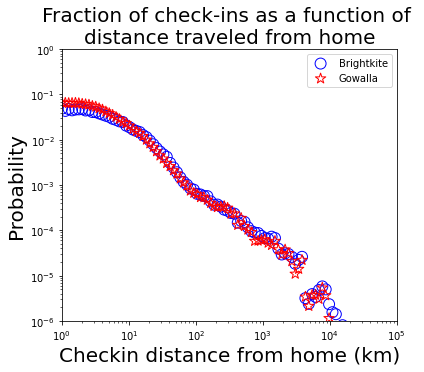

In [183]:
# Function that computes the distributions of the values in data and plots it using a scatter plot.
# The arguments are:
#    - data: the array containing the values for which we want to compute the distribution.
#    - ax: the axes of the plot on shich we will apply the scatter function.
#    - marker, color, m_size: type, edgecolor and size of the markers we want. m_size is set to 120 by default.
#    - bins_max, num_bins: max value for the logspace function, and number of values wanted for the bins. 
#                          Defalut values set respectively to 10^5 and 100 for this plot.
def plot_probability(data, ax, marker, color, label, m_size = 120, bins_max = pow(10,5), num_bins = 100):
    log_bins=np.logspace(0, np.log10(bins_max), num = num_bins)
    hist_values, bins = np.histogram(data, bins= log_bins, density=True)
    ax.scatter(bins[:-1], hist_values, marker= marker, s=m_size, facecolors='none', edgecolors=color, label=label)

# Doing the final plot. Setting the figure size to (6,5) arbitrarily (slightly larger than tall).
fig, ax = plt.subplots(figsize=(6, 5))

# BRIGHTKITE – computing and scatter plotting the distribution of home distances between friends.
plot_probability(b_checkins['dist_from_home'], ax, 'o', 'b', 'Brightkite')

# GOWALLA – computing and scatter plotting the distribution of home distances between friends.
plot_probability(g_checkins['dist_from_home'], ax, '*', 'r', 'Gowalla')

# Setting the axes' scales to be logarithmic.
ax.set_xscale("log")
ax.set_yscale("log")

#Setting the limits of the axes to match the ones in the paper's plot.
ax.set_xlim(10e-1, 10e4)
ax.set_ylim(10e-7, 10e-1)

# Naming the axes and resizing the labels
ax.set_xlabel('Checkin distance from home (km)', size=20)
ax.set_ylabel('Probability', size=20)

# Adding the color legend and the title of the plot.
ax.set_title("Fraction of check-ins as a function of \ndistance traveled from home", size=20)
ax.legend()

In [5]:
g_Temp.to_csv(r'./Data/g_final.txt.gz', compression = 'gzip')

In [6]:
b_temp.to_csv(r'./Data/b_final.txt.gz', compression = 'gzip')